Based on:  
https://www.tensorflow.org/datasets/keras_example  
https://www.tensorflow.org/tutorials/images/data_augmentation


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

from frouros.detectors.data_drift import MMD
from frouros.callbacks import PermutationTestDistanceBased
import numpy as np

2023-07-21 14:02:44.875458: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 14:02:44.901837: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 14:02:44.902703: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 14:02:45.426984: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# MNIST input pipeline


In [2]:
# Load the MNIST dataset
(ds_train, ds_test), metadata = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

INFO:absl:Load dataset info from /home/borja/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/home/borja/tensorflow_datasets/mnist/3.0.1)
2023-07-21 14:02:46.613688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-21 14:02:46.613990: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
INFO:absl:Constructing tf.data.Dataset mnist for split ['train', 'test'], fro

In [3]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.0


ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(metadata.splits["train"].num_examples)
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [4]:
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(32)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

# Create image encoder


In [5]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                layers.Flatten(input_shape=(28, 28)),
                layers.Dense(latent_dim, activation="relu"),
            ]
        )
        self.decoder = tf.keras.Sequential(
            [
                layers.Dense(784, activation="sigmoid"),
                layers.Reshape((28, 28, 1)),
            ]
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = Autoencoder(latent_dim=64)

In [6]:
autoencoder.compile(optimizer="adam", loss=tf.keras.losses.MeanAbsoluteError())

In [7]:
_train = ds_train.map(lambda x: (x, x))
_test = ds_test.map(lambda x: (x, x))
autoencoder.fit(_train, epochs=3, validation_data=_test)

Epoch 1/3
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0909 - val_loss: 0.0701
Epoch 2/3
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0655 - val_loss: 0.0629
Epoch 3/3
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0621 - val_loss: 0.0616


# Data augmentation


In [8]:
data_augmentation = tf.keras.Sequential([layers.RandomRotation(0.5)])
ds_augmented = ds_train.map(lambda x: data_augmentation(x))

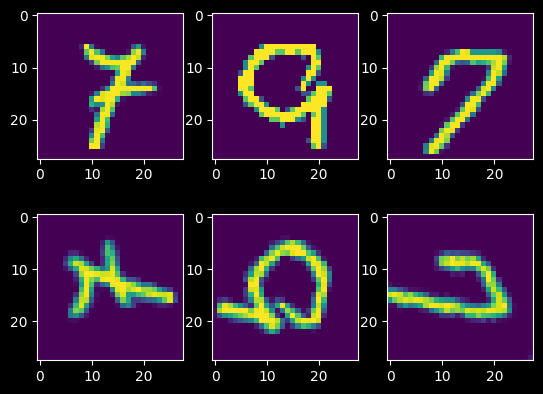

In [9]:
images = next(iter(ds_train)).numpy()
augmented = data_augmentation(images)
fig, ax = plt.subplots(nrows=2, ncols=3)

for i in range(ax.shape[1]):
    ax[0, i].imshow(images[i])
    ax[1, i].imshow(augmented[i])

# Data encoding


In [10]:
encoded_train = ds_train.map(lambda x: autoencoder.encoder(x))
encoded_train = encoded_train.unbatch()
encoded_augmented = ds_augmented.map(lambda x: autoencoder.encoder(x))
encoded_augmented = encoded_augmented.unbatch()

# Data drift detection


A significance level of $\alpha = 0.05$ is set to perform the hypothesis test.


In [11]:
alpha = 0.01

In [12]:
num_samples = 1000
samples_train = encoded_train.take(num_samples).as_numpy_iterator()
samples_augmented = encoded_augmented.take(num_samples).as_numpy_iterator()

Maximum Mean Discrepancy (MMD) {cite:p}`JMLR:v13:gretton12a` imported from Frouros is used with a Radial Basis Function kernel (RBF), set by default in MMD. In addition to calculating the corresponding MMD statistic, p-value is estimated using permutation test.


In [13]:
detector = MMD(
    callbacks=[
        PermutationTestDistanceBased(
            num_permutations=1000,
            random_state=43,
            num_jobs=-1,
            name="permutation_test",
            verbose=False,
        ),
    ],
)
_ = detector.fit(X=np.stack(samples_train))

/home/borja/miniconda3/envs/DEEPaaS/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


Compare each test dataset to the dataset fitted by MMD.


In [14]:
mmd, callbacks_logs = detector.compare(X=np.stack(samples_augmented))

p_value = callbacks_logs["permutation_test"]["p_value"]
print(round(p_value, 4))

0.7988


In [15]:
drift = p_value > alpha
drift

True